# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/6_cornernet_lite/installation
     
 - Select the right requirements file and run
 
     - chmod +x install.sh
     - ./install.sh

# About the network

1. Paper on CornerNet: https://arxiv.org/abs/1808.01244

2. Paper on CornerNet-Lite: https://arxiv.org/abs/1904.08900

3. Blog 1 on CornerNet: https://joshua19881228.github.io/2019-01-20-CornerNet/

4. Blog 2 on CornerNet: https://zhangtemplar.github.io/anchor-free-detection/

5. Blog 3 on CornerNet: https://opencv.org/latest-trends-of-object-detection-from-cornernet-to-centernet-explained-part-i-cornernet/

6. Blog 4 on CornerNet: https://towardsdatascience.com/centernet-keypoint-triplets-for-object-detection-review-a314a8e4d4b0

7. Blog 5 on CornerNet: https://medium.com/@andersasac/the-end-of-anchors-improving-object-detection-models-and-annotations-73828c7b39f6

## Get Dataset

 - Credits: https://github.com/switchablenorms/DeepFashion2
 


### Note: Fill the data access form (in the link above) before downloading the dataset

### Deep Fashion 2 Training Images

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lQZOIkO-9L0QJuk_w1K8-tRuyno-KvLK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lQZOIkO-9L0QJuk_w1K8-tRuyno-KvLK" -O train.zip && rm -rf /tmp/cookies.txt

In [ ]:
%%capture
!unzip train.zip

In [ ]:
%%capture
!unzip validation.zip

# Convert Ground truth to Monk format

In [8]:
!pip install -U tqdm

     |################################| 61kB 2.2MB/s eta 0:00:011


In [2]:
with open('/home/ubuntu/train/annos/159970.json') as json_file:
    data = json.load(json_file)

In [6]:
for key,row in data.items():
    #print(key)
    if key[:4] == 'item':
        print(key,row['category_name'])    

item2 skirt
item1 long sleeve top
item3 trousers


## Convert training labels

In [30]:
import json
from glob import glob
from tqdm import tqdm

In [31]:
def convertdf2_Monk(annos_path,val=False):
    if val == True:
        h = open("val_labels.csv",'w')
    else:
        h = open("train_labels.csv",'w')
    h.write("Id,Labels\n")
    annos_list = glob(annos_path + "/*.json")
    for i in tqdm(annos_list):
        with open(i) as f:
            data = json.load(f)
            image_name = i.split('/')[-1].split('.')[0] + '.jpg'
            h.write(image_name+",")
            labels = []
            for key,row in data.items():
                if key[:4] == 'item':
                    bbox = row['bounding_box']
                    bbox = list(map(str,bbox))
                    bbox.append("_".join(row['category_name'].split(" ")))
                    h.write(" ".join(bbox))
                    h.write(" ")
            h.write("\n")
    h.close()

In [20]:
convertdf2_Monk("./train/annos")

100%|██████████| 191961/191961 [01:51<00:00, 1717.62it/s]


In [32]:
convertdf2_Monk("./validation/annos",val=True)

100%|██████████| 32153/32153 [00:06<00:00, 5002.90it/s]


## Dataset Prepare

In [8]:
!mkdir fashion
#!mkdir fashion/Images
!mkdir fashion/Train
#!mkdir fashion/Val

In [33]:
!mkdir fashion/Val

mkdir: cannot create directory 'fashion/Val': File exists


In [15]:
import pandas as pd
gt = pd.read_csv("train_labels.csv")
print(gt.head())

           Id                                             Labels
0  039971.jpg                            0 45 467 830 vest_dress
1  145127.jpg                        221 234 546 1099 vest_dress
2  078829.jpg  63 13 325 332 short_sleeve_top115 278 301 519 ...
3  097729.jpg           202 253 445 475 skirt266 97 425 301 vest
4  082554.jpg  1 332 277 682 skirt109 196 467 487 short_sleev...


In [16]:
import shutil
from tqdm import tqdm

for m in tqdm(list(gt.Id)):
    inPath = "./train/image/{}".format(m)
    outPath = "./fashion/Train/{}".format(m)
    shutil.copy(inPath,outPath)

100%|██████████| 191961/191961 [05:34<00:00, 573.83it/s]


In [34]:
import pandas as pd
gt = pd.read_csv("val_labels.csv")
print(gt.head())

           Id                                             Labels
0  025176.jpg  369 315 604 589 long_sleeve_top 326 317 600 65...
1  000104.jpg                       0 1 467 622 long_sleeve_top 
2  001843.jpg    0 54 73 99 trousers 0 0 82 64 short_sleeve_top 
3  012656.jpg       211 350 433 585 shorts 182 123 441 411 vest 
4  026592.jpg  158 442 410 831 trousers 267 196 527 500 short...


In [36]:
import shutil
from tqdm import tqdm

for m in tqdm(list(gt.Id)):
    inPath = "./validation/image/{}".format(m)
    outPath = "./fashion/Val/{}".format(m)
    shutil.copy(inPath,outPath)

100%|██████████| 32153/32153 [00:04<00:00, 7842.92it/s]


In [21]:
!cp train_labels.csv ./fashion/train_labels.csv

In [37]:
!cp val_labels.csv ./fashion/val_labels.csv

# Monk 2 COCO

### Generate Training COCO labels

In [2]:
!pip install dicttoxml

In [22]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [23]:
root = "./fashion/";
img_dir = "Train/";
anno_file = "train_labels.csv";

In [24]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [25]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [26]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [27]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [28]:
df = pd.read_csv(input_annotations_path);
df.dropna()
columns = df.columns

In [29]:
delimiter = " ";

In [30]:
list_dict = [];
anno = [];
for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in tqdm(range(len(anno))):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 13/13 [00:00<00:00, 65222.43it/s]


In [31]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 191961/191961 [20:17<00:00, 157.67it/s]


### Generate Validation COCO Labels

In [42]:
import cv2

In [38]:
root = "./fashion/";
img_dir = "Val/";
anno_file = "val_labels.csv";

In [39]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [43]:
def convertMonk2COCO(annotations_path,images_folder,img_dir):
  if not os.path.isdir(annotations_path):
      os.mkdir(annotations_path)
      
  input_images_folder = images_folder;
  input_annotations_path = root + "/" + anno_file;

  output_dataset_path = root;
  output_image_folder = input_images_folder;
  output_annotation_folder = annotations_path;

  tmp = img_dir.replace("/", "");
  output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
  output_classes_file = output_annotation_folder + "/classes.txt";

  if not os.path.isdir(output_annotation_folder):
      os.mkdir(output_annotation_folder);

  df = pd.read_csv(input_annotations_path);
  df.dropna()
  columns = df.columns
  delimiter = " ";
  list_dict = [];
  anno = [];
  for i in range(len(df)):
      img_name = df[columns[0]][i];
      labels = df[columns[1]][i];
      tmp = labels.split(delimiter);
      for j in range(len(tmp)//5):
          label = tmp[j*5+4];
          if(label not in anno):
              anno.append(label);
      anno = sorted(anno)
      
  for i in tqdm(range(len(anno))):
      tmp = {};
      tmp["supercategory"] = "master";
      tmp["id"] = i;
      tmp["name"] = anno[i];
      list_dict.append(tmp);

  anno_f = open(output_classes_file, 'w');
  for i in range(len(anno)):
      anno_f.write(anno[i] + "\n");
  anno_f.close();

  coco_data = {};
  coco_data["type"] = "instances";
  coco_data["images"] = [];
  coco_data["annotations"] = [];
  coco_data["categories"] = list_dict;
  image_id = 0;
  annotation_id = 0;


  for i in tqdm(range(len(df))):
      img_name = df[columns[0]][i];
      labels = df[columns[1]][i];
      tmp = labels.split(delimiter);
      image_in_path = input_images_folder + "/" + img_name;
      img = cv2.imread(image_in_path, 1);
      h, w, c = img.shape;

      images_tmp = {};
      images_tmp["file_name"] = img_name;
      images_tmp["height"] = h;
      images_tmp["width"] = w;
      images_tmp["id"] = image_id;
      coco_data["images"].append(images_tmp);
      

      for j in range(len(tmp)//5):
          x1 = int(tmp[j*5+0]);
          y1 = int(tmp[j*5+1]);
          x2 = int(tmp[j*5+2]);
          y2 = int(tmp[j*5+3]);
          label = tmp[j*5+4];
          annotations_tmp = {};
          annotations_tmp["id"] = annotation_id;
          annotation_id += 1;
          annotations_tmp["image_id"] = image_id;
          annotations_tmp["segmentation"] = [];
          annotations_tmp["ignore"] = 0;
          annotations_tmp["area"] = (x2-x1)*(y2-y1);
          annotations_tmp["iscrowd"] = 0;
          annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
          annotations_tmp["category_id"] = anno.index(label);

          coco_data["annotations"].append(annotations_tmp)
      image_id += 1;

  outfile =  open(output_annotation_file, 'w');
  json_str = json.dumps(coco_data, indent=4);
  outfile.write(json_str);
  outfile.close();



In [44]:
convertMonk2COCO(annotations_path=annotations_path,images_folder=images_folder,img_dir=img_dir)

100%|██████████| 32153/32153 [02:58<00:00, 180.49it/s]


## Setup Monk

In [3]:
!git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 910, done.
remote: Counting objects: 100% (910/910), done.
remote: Compressing objects: 100% (836/836), done.
remote: Total 3434 (delta 178), reused 700 (delta 67), pack-reused 2524
Receiving objects: 100% (3434/3434), 130.83 MiB | 4.41 MiB/s, done.
Resolving deltas: 100% (533/533), done.
Checking out files: 100% (4080/4080), done.


In [ ]:
!cd Monk_Object_Detection/6_cornernet_lite/installation 

In [7]:
!chmod +x install.sh

In [ ]:
!./install.sh

In [ ]:
!cd ../../../

## NOTE: Restart Runtime (If Using Colab)

In [9]:
import os
import sys

In [10]:
sys.path.append("Monk_Object_Detection/6_cornernet_lite/lib/")

In [47]:
from train_detector import Detector

### Training

In [48]:
gtf = Detector();

In [49]:
root_dir = "./";
coco_dir = "./fashion"
img_dir = ""
set_dir = "Train"

In [50]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=16, use_gpu=True, num_workers=12)

In [51]:
root_dir = "./";
coco_dir = "./fashion"
img_dir = ""
set_dir = "Val"

In [52]:
gtf.Val_Dataset(root_dir, coco_dir, img_dir, set_dir)

In [53]:
gtf.Model(model_name="CornerNet_Saccade")

In [55]:
gtf.Hyper_Params(lr=0.0001, total_iterations=100000, val_interval=1000)

In [ ]:
gtf.Setup();

In [ ]:
gtf.Train();

# Inference

In [1]:
import os
import sys

In [2]:
sys.path.append("Monk_Object_Detection/6_cornernet_lite/lib/")

In [3]:
from infer_detector import Infer

In [4]:
gtf = Infer();

In [5]:
class_list = ["long_sleeve_dress","long_sleeve_outwear","long_sleeve_top","short_sleeve_dress","short_sleeve_outwear","short_sleeve_top","shorts","skirt","sling","sling_dress","trousers","vest","vest_dress"]

In [14]:
gtf.Model(class_list, 
          base="CornerNet_Saccade", 
          model_path="./cache/nnet/CornerNet_Saccade/CornerNet_Saccade_best.pkl")

total parameters: 116866025
loading from ./cache/nnet/CornerNet_Saccade/CornerNet_Saccade_best.pkl


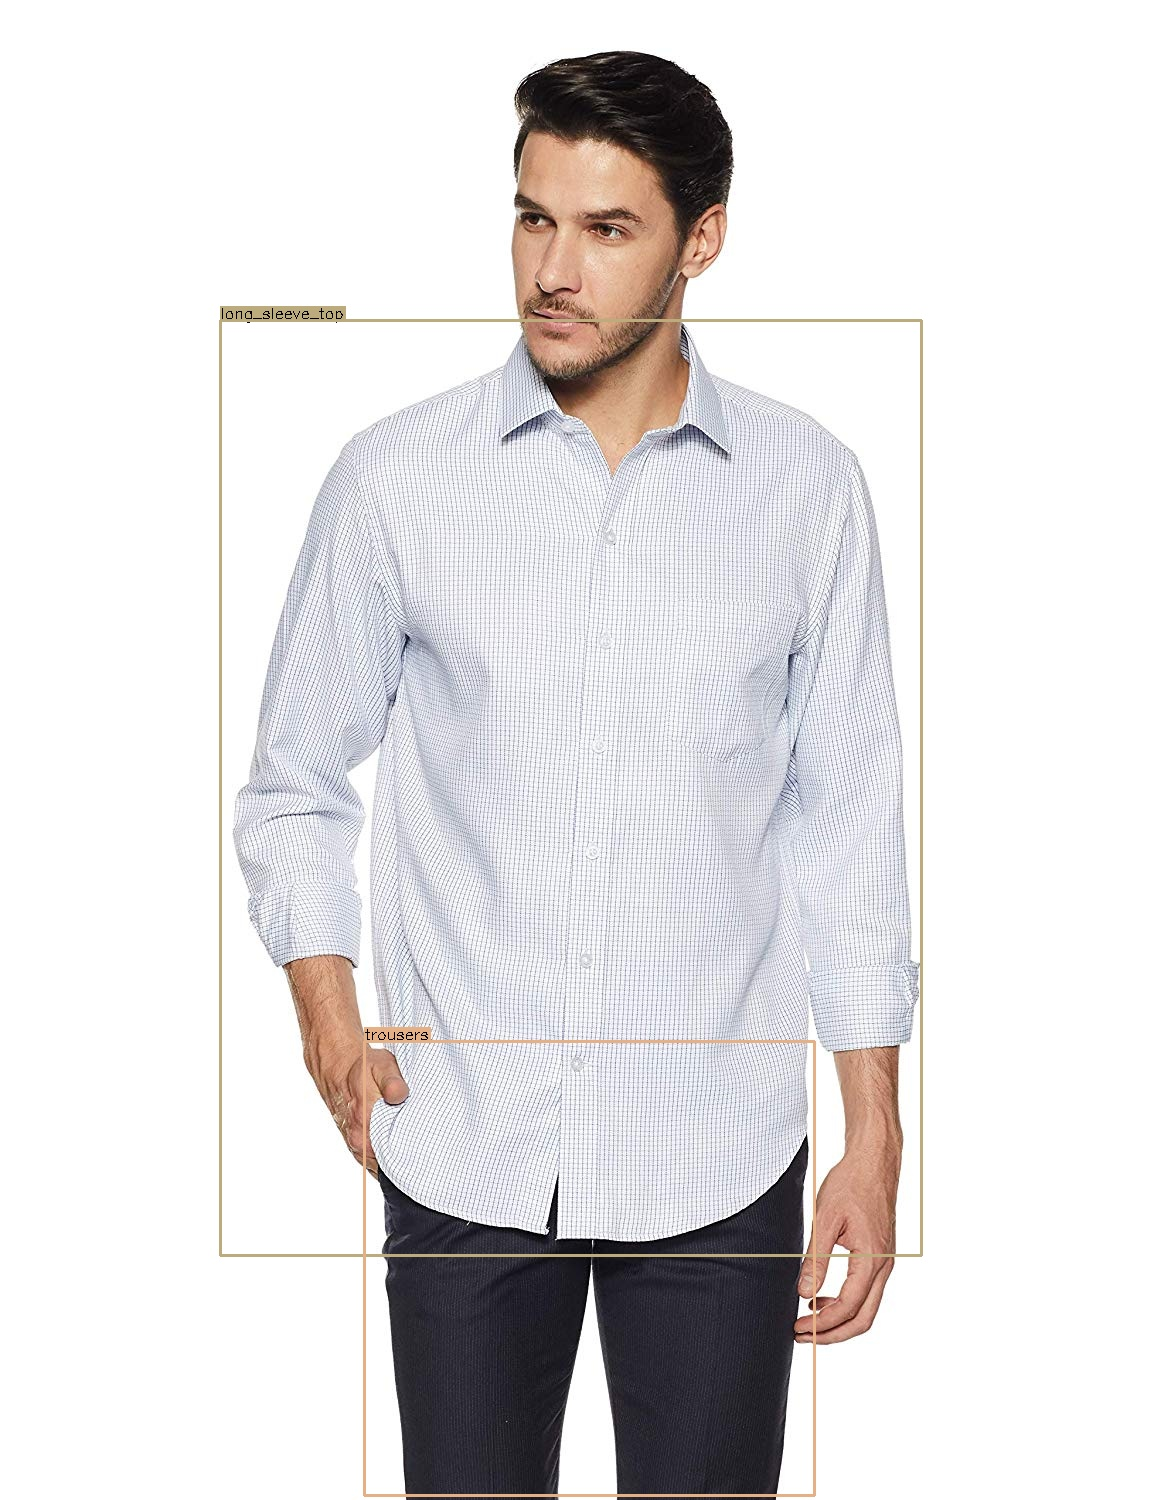

In [19]:
boxes = gtf.Predict("../sample_dataset/test_fashion/test1.jpg", vis_thresh=0.4, output_img="output.jpg")
from IPython.display import Image
Image(filename='output.jpg')

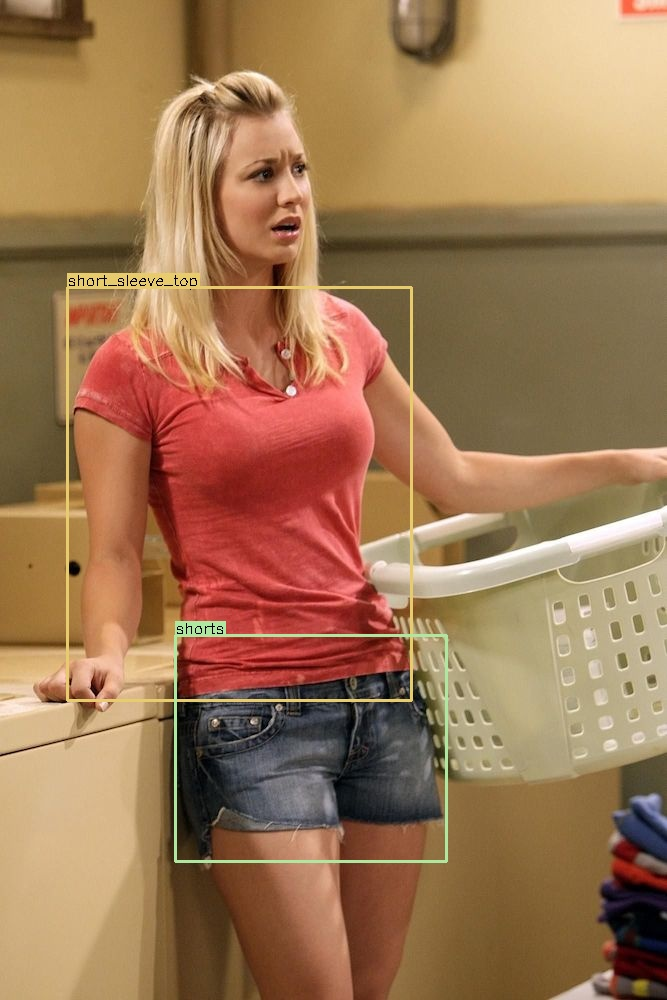

In [20]:
boxes = gtf.Predict("../sample_dataset/test_fashion/test2.jpg", vis_thresh=0.4, output_img="output.jpg")
from IPython.display import Image
Image(filename='output.jpg')

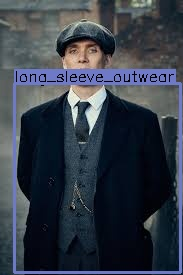

In [21]:
boxes = gtf.Predict("../sample_dataset/test_fashion/test3.jpg", vis_thresh=0.4, output_img="output.jpg")
from IPython.display import Image
Image(filename='output.jpg')